In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import datetime 
import talib as ta 
import tensorflow as tf 
import random 
import pickle 
import pyfolio as pf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping 

import warnings 
warnings.filterwarnings('ignore') 

c:\Users\vidya\.conda\envs\pyten\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
data_df = yf.download('SPY',period='10y') 

[*********************100%%**********************]  1 of 1 completed


In [3]:
data_df.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-26,195.610001,195.630005,194.130005,195.440002,163.585968,84312000
2014-06-27,194.979996,195.880005,194.889999,195.820007,163.904022,71445100
2014-06-30,195.699997,196.169998,195.529999,195.720001,163.820328,70201200
2014-07-01,196.199997,197.630005,196.130005,197.029999,164.916794,90470000
2014-07-02,197.050003,197.479996,196.960007,197.229996,165.084198,52475000


In [4]:
def create_features(data):
    features_list = []
    data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
    data['rsi'] = ta.RSI(data['Close'].values)
    #data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
    data ['sma'] = data['Close'].rolling(window=20).mean()    
    data['lma'] = data['Close'].rolling(window=50).mean()
    data['obv'] = ta.OBV(data['Close'], data['Volume'])
    data['mfi'] = ta.MFI(data['High'], data['Low'], data['Close'], data['Volume'])
    features_list +=['upper_band','middle_band','lower_band','macd','rsi','sma','lma','obv','mfi']
    data = data.drop(['Adj Close', 'Open','High','Low','Volume'], axis=1) 
    data.dropna(inplace=True)
    return data,features_list 

In [5]:
data_cr, list = create_features(data_df)

In [6]:
data_cr.head() 

,Close,upper_band,middle_band,lower_band,macd,macdsignal,macdhist,rsi,sma,lma,obv,mfi
Date,,,,,,,,,,,,
2014-09-05,201.110001,201.214843,200.628003,200.041163,1.331824,1.093058,0.238766,67.844196,198.215501,197.0130,81132100.0,71.853408
2014-09-08,200.589996,201.185252,200.604001,200.022750,1.300225,1.134491,0.165734,63.743099,198.583000,197.1160,16986100.0,71.553573
2014-09-09,199.320007,201.525189,200.346002,199.166815,1.159341,1.139461,0.019880,54.998916,198.859000,197.1860,-71604900.0,63.315298
2014-09-10,200.070007,201.444430,200.260004,199.075578,1.095579,1.130684,-0.035106,58.609923,199.186001,197.2730,-4353900.0,63.119374
2014-09-11,200.300003,201.461578,200.278003,199.094428,1.051484,1.114844,-0.063360,59.678450,199.459001,197.3384,62420500.0,63.087246


In [20]:
# Step 2: Data preprocessing
def preprocess_data(data):
    # Extract 'Close', price is our target variable
    #df = data[['Close']]   
    df = data
    list_col = [data.columns]
    df.dropna(inplace=True)    
    # Normalize the data to a range between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(df, columns=list_col)
    scaled_df.index = data.index   
    # out_scaler = MinMaxScaler(feature_range=(0, 1))
    # temp = out_scaler.fit_transform(data['Close'].values.reshape(-1,1))    
    return df, scaler, scaled_df #,out_scaler,temp  

In [21]:
df, scaler, scaled_df = preprocess_data(data_cr) 

In [22]:
scaled_df.head() 

,Close,upper_band,middle_band,lower_band,macd,macdsignal,macdhist,rsi,sma,lma,obv,mfi
Date,,,,,,,,,,,,
2014-09-05,0.049914,0.037551,0.042970,0.054139,0.758649,0.745677,0.519070,0.726105,0.028188,0.011827,0.728160,0.727206
2014-09-08,0.048492,0.037470,0.042904,0.054088,0.757695,0.747149,0.513114,0.667561,0.029242,0.012139,0.715526,0.723688
2014-09-09,0.045018,0.038406,0.042189,0.051719,0.753439,0.747326,0.501217,0.542735,0.030034,0.012351,0.698076,0.627045
2014-09-10,0.047069,0.038184,0.041950,0.051467,0.751514,0.747014,0.496732,0.594283,0.030972,0.012614,0.711322,0.624746
2014-09-11,0.047699,0.038231,0.042000,0.051519,0.750182,0.746451,0.494427,0.609537,0.031755,0.012812,0.724475,0.624370


In [23]:
scaled_df.isna().sum().sum() 

0

In [24]:
len(scaled_df.columns) 

12

In [28]:
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data)-sequence_length):
        x = data[i:i+sequence_length,0:12]
        y = data[i+sequence_length,0]
        sequences.append(x)
        target.append(y) 
    return np.array(sequences), np.array(target) 

In [29]:
data_seq, data_tar = create_sequences(df, 10)

In [34]:
len(data_tar)  

2457

In [35]:
len(data_seq)   

2457

In [39]:
df

array([[0.04991385, 0.03755104, 0.04297029, ..., 0.01182686, 0.72816041,
        0.72720555],
       [0.04849163, 0.0374695 , 0.04290378, ..., 0.01213881, 0.71552559,
        0.72368818],
       [0.04501821, 0.0384062 , 0.04218881, ..., 0.01235082, 0.69807586,
        0.62704488],
       ...,
       [0.98911473, 0.99883265, 1.        , ..., 0.99644316, 0.57742658,
        0.73256134],
       [0.98427372, 0.99887954, 0.99997781, ..., 0.99794173, 0.56845881,
        0.65046991],
       [0.98998995, 0.99735341, 0.99871971, ..., 1.        , 0.57593109,
        0.65318452]])

In [36]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, activation='tanh',return_sequences=True, input_shape=input_shape))
    #model.add(Dropout(0.2))
    model.add(LSTM(units=100, activation='tanh',return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(50,activation='tanh'))
    model.add(Dense(25,activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'linear'))
    #model.add(Dropout(0.2))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
    return model 

In [50]:
# Train model
def train_model(data_seq, data_tar):
    train_size = int(len(data_seq)*0.8)
    x_train, x_test = data_seq[:train_size], data_seq[train_size:]
    y_train, y_test = data_tar[:train_size], data_tar[train_size:]

    input_shape = (x_train.shape[1], x_train.shape[2])
    model = build_lstm_model(input_shape)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(x_train, y_train, batch_size=10, epochs=50, validation_data=(x_test, y_test))
    plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()  

    #Evaluating model
    train_acc = model.evaluate(x_train, y_train, verbose=0)
    test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Train: %.5f, Test: %.5f' % (train_acc[0], test_acc[0]))
    print('Train: %.5f, Test: %.5f' % (train_acc[1], test_acc[1]))
    
    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model 

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0012 - loss: 0.0146 - val_accuracy: 0.0020 - val_loss: 0.0035
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 8.9862e-04 - loss: 3.6809e-04 - val_accuracy: 0.0020 - val_loss: 0.0027
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 7.3302e-04 - loss: 3.9381e-04 - val_accuracy: 0.0020 - val_loss: 0.0019
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 2.7352e-04 - loss: 3.7047e-04 - val_accuracy: 0.0020 - val_loss: 0.0028
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 3.8567e-04 - loss: 3.4706e-04 - val_accuracy: 0.0020 - val_loss: 0.0036
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 3.9116e-04 - loss: 3.3360e-04 - val_accuracy: 0.0020 - val_loss: 0.0017
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.7098e-04 - loss: 2.3973e-04 - val_accuracy: 0.0020 - val_loss: 4.4647e-04
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

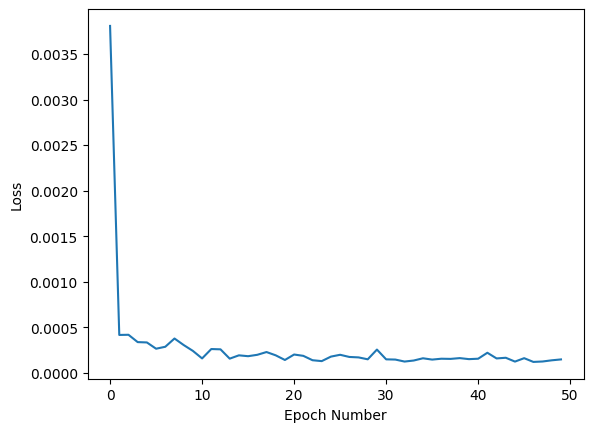

Train: 0.00010, Test: 0.00054
Train: 0.00051, Test: 0.00203


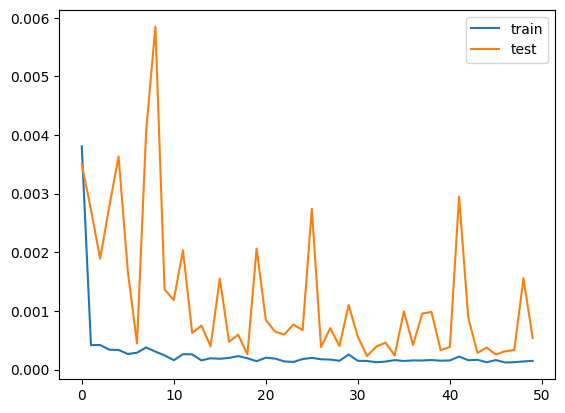

In [51]:
model = train_model(data_seq, data_tar) 

In [43]:
model 

<Sequential name=sequential, built=True>